<a href="https://colab.research.google.com/github/DilendraSajini/Image_Analysis/blob/main/main%20/source%20code/Data_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install patchify

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from pandas import DataFrame
from typing import List
import numpy as np
from sklearn.model_selection import train_test_split
from typing import Tuple
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from patchify import patchify

   fold  mag    grp                                           filename  label  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...      0   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...      0   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...      0   
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...      0   
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...      0   

   sub_type  
0  adenosis  
1  adenosis  
2  adenosis  
3  adenosis  
4  adenosis  
(25880, 6)
(13665, 6)


array([[<Axes: title={'center': 'fold'}>,
        <Axes: title={'center': 'mag'}>],
       [<Axes: title={'center': 'label'}>, <Axes: >]], dtype=object)

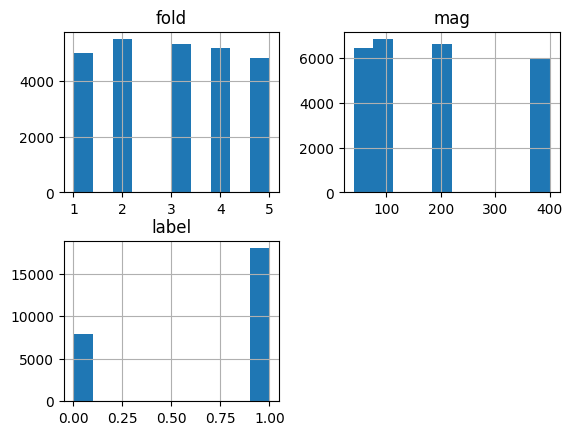

In [ ]:
image_info = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Folds.csv/Folds.csv')
classes = dict(benign=0, malignant=1)
image_info["label"] = (image_info["filename"].str.extract("(malignant|benign)"))
image_info["label"] =image_info["label"].map(classes)
image_info["sub_type"] = image_info["filename"].str.extract("(adenosis|fibroadenoma|phyllodes_tumor|tubular_adenoma|ductal_carcinoma|lobular_carcinoma|mucinous_carcinoma|papillary_carcinoma)")
print(image_info.head())
train = image_info.query("grp == 'train'")
test = image_info.query("grp == 'test'")
print(train.shape)
print(test.shape)
train.hist()

In [ ]:
image_info

fold  mag    grp                                           filename  \
0         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
3         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
4         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
...     ...  ...    ...                                                ...   
39540     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
39541     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
39542     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
39543     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
39544     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   

       label             sub_type  
0          0             adenosis  
1          0             adenosis  
2          0             adenosis  
3          0             adenosis  
4          0             adenosis  
...      ...                  ...  
39540      1  papillary_carcinoma  
39541      1  papillary_carcinoma  
39542      1  papillary_carcinoma  
39543      1  papillary_carcinoma  
39544      1  papillary_carcinoma  

[39545 rows x 6 columns]

In [ ]:
grouped_ = image_info.groupby(['label','fold','sub_type'])
group_counts = grouped_.size()
print(group_counts)

label  fold  sub_type           
0      1     adenosis                444
             fibroadenoma           1014
             phyllodes_tumor         453
             tubular_adenoma         569
       2     adenosis                444
             fibroadenoma           1014
             phyllodes_tumor         453
             tubular_adenoma         569
       3     adenosis                444
             fibroadenoma           1014
             phyllodes_tumor         453
             tubular_adenoma         569
       4     adenosis                444
             fibroadenoma           1014
             phyllodes_tumor         453
             tubular_adenoma         569
       5     adenosis                444
             fibroadenoma           1014
             phyllodes_tumor         453
             tubular_adenoma         569
1      1     ductal_carcinoma       3451
             lobular_carcinoma       626
             mucinous_carcinoma      792
             papillary_c

In [ ]:
def balanced_sub_type_images(selected_data: DataFrame,selected_fold: int,magnification_factor: int,cap: int):
  sub_types_0 = ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma']
  sub_types_1 = ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
  # Select data for sub_types in category 0
  selected_data_1 = get_sub_type_images(selected_data,selected_fold,magnification_factor,sub_types_0,0,cap)
  print("benign : " + str(selected_data_1.shape))
  # Select data for sub_types in category 1
  selected_data_2 = get_sub_type_images(selected_data,selected_fold,magnification_factor,sub_types_1,1,cap)
  print("malignant : " + str(selected_data_2.shape))
  return pd.concat([selected_data_1,selected_data_2])
def get_sub_type_images(image_data: DataFrame,selected_fold: int,magnification_factor: int,sub_types:List[str], label:int,cap: int):
   selected_data = pd.DataFrame()# Empty DataFrame to store the selected data
   for sub_type in sub_types:
      data = select_images_fold_mag_category_sub_type(image_data,selected_fold, magnification_factor, label, sub_type)
      print(sub_type + " : "+ str(data.shape))
      selected_data = pd.concat([selected_data,data.head(cap)])
   return selected_data
def select_images_fold_mag_category_sub_type(image_data: DataFrame, selected_fold: int,magnification_factor: int,category: int,sub_type: str):
  selected_fold_data = image_data.query("fold == @selected_fold").copy()
  selected_fold_data["filename"] = ("/content/drive/MyDrive/Colab Notebooks/Folds.csv/"
                                    + selected_fold_data["filename"])
  selected_data = selected_fold_data.query("mag == "+ str(magnification_factor) + "and label ==" + str(category) + "and sub_type== '"+sub_type +"'")
  return selected_data
def load_image(filename: str, label: int) -> Tuple[tf.Tensor, str]:
    file = tf.io.read_file(filename)
    img = tf.image.decode_png(file, channels=3)
    return img, label
folder = 1
magnification = 40
cap=50  # pick 100 from each sub type
train_70_balanced = balanced_sub_type_images(train,folder,magnification,cap)
test_30_balanced =balanced_sub_type_images(test,folder,magnification,cap)

grouped_multiple_columns = train_70_balanced.groupby(['sub_type'])
group_counts = grouped_multiple_columns.size()
print(group_counts)


grouped_multiple_columns = test_30_balanced.groupby(['sub_type'])
group_counts = grouped_multiple_columns.size()
print(group_counts)

adenosis : (64, 6)
fibroadenoma : (173, 6)
phyllodes_tumor : (51, 6)
tubular_adenoma : (82, 6)
benign : (200, 6)
ductal_carcinoma : (566, 6)
lobular_carcinoma : (73, 6)
mucinous_carcinoma : (143, 6)
papillary_carcinoma : (98, 6)
malignant : (200, 6)
adenosis : (50, 6)
fibroadenoma : (80, 6)
phyllodes_tumor : (58, 6)
tubular_adenoma : (67, 6)
benign : (200, 6)
ductal_carcinoma : (298, 6)
lobular_carcinoma : (83, 6)
mucinous_carcinoma : (62, 6)
papillary_carcinoma : (47, 6)
malignant : (197, 6)
sub_type
adenosis               50
ductal_carcinoma       50
fibroadenoma           50
lobular_carcinoma      50
mucinous_carcinoma     50
papillary_carcinoma    50
phyllodes_tumor        50
tubular_adenoma        50
dtype: int64
sub_type
adenosis               50
ductal_carcinoma       50
fibroadenoma           50
lobular_carcinoma      50
mucinous_carcinoma     50
papillary_carcinoma    47
phyllodes_tumor        50
tubular_adenoma        50
dtype: int64


In [ ]:
SEED = np.random.seed(42)
X_train, X_valid, y_train, y_valid = train_test_split(
    train_70_balanced["filename"], train_70_balanced["label"], random_state=SEED)
#IMG_SIZE = (224, 224)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
             .map(lambda filename, label : load_image(filename, label))
validation_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))\
                  .map(lambda filename, label : load_image(filename, label))
test_ds = test_30_balanced.sample(frac=1, random_state=SEED)  # shuffle test data
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_ds["filename"], test_ds["label"])).map(lambda filename, label : load_image(filename, label))

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
print(train_ds_size)
print(validation_ds_size)
print(test_ds_size)

300
100
397


In [ ]:
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

(460, 700, 3)
(460, 700, 3)
(460, 700, 3)
(460, 700, 3)
(460, 700, 3)
(460, 700, 3)
(460, 700, 3)
(460, 700, 3)
(460, 700, 3)
(460, 700, 3)


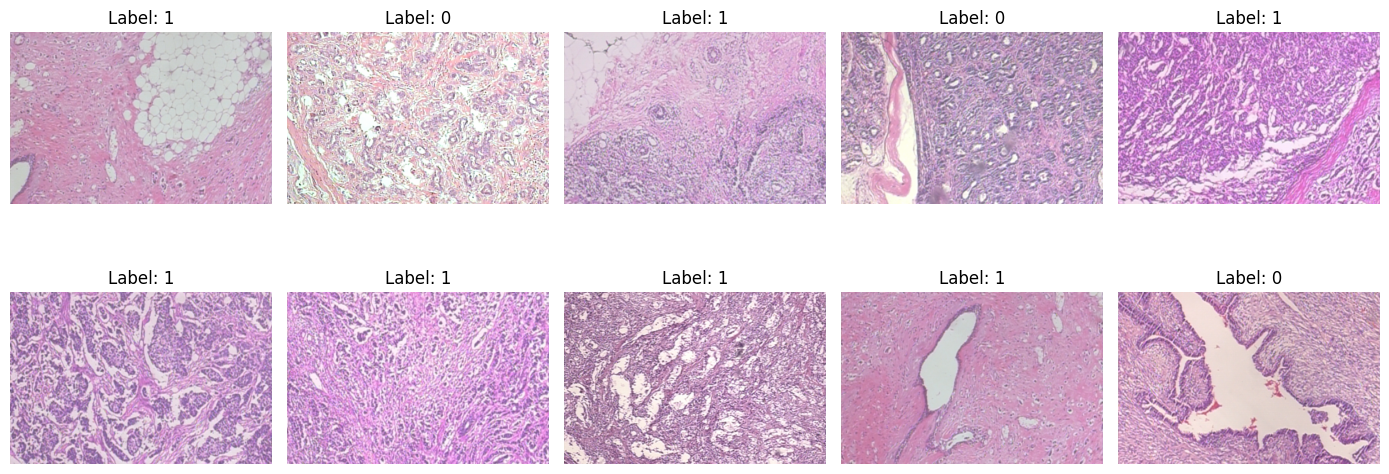

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()

for i, (image, label) in enumerate(test_ds):
    axes[i].imshow(image.numpy().astype(np.uint8))
    print(image.shape)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

    if i == 9:  # Display only the first 10 elements
        break

plt.tight_layout()
plt.show()

In [ ]:
WSI_directory_path ="/content/drive/MyDrive/Colab Notebooks/WSI"
patch_directory_path ="/content/drive/MyDrive/Colab Notebooks/sample"


In [ ]:
def getPatchData(data_ds: tf.data.Dataset) -> Tuple[tf.Tensor, str]:
  all_img_patches = []
  all_img_patches_labels = []

  for index, (image, label) in enumerate(data_ds):
      patches_img = patchify(image.numpy(), (224, 224,3), step=224)
      for i in range(patches_img.shape[0]):
          for j in range(patches_img.shape[1]):

              single_patch_img = patches_img[i,j,:,:]
              single_patch_img = (single_patch_img.astype('float32')) / 255.

              all_img_patches.append(single_patch_img)
              all_img_patches_labels.append(label)

  images_patch = np.array(all_img_patches)
  images_patch_labels = np.array(all_img_patches_labels)
  print(images_patch.shape)
  return images_patch,images_patch_labels

def savePatches(type:str, images_patch:np.ndarray, images_patch_labels:np.ndarray):
  for i, (image, label) in enumerate(zip(images_patch, images_patch_labels)):
      image_data = (image * 255).astype(np.uint8)
      image_data = image_data.squeeze()
      image = Image.fromarray(image_data)
      filename = f'image_{i:04d}_{label}.png'
      if(label == 0):
          image.save(f'{patch_directory_path}/{type}/benign/{filename}')
      elif(label == 1):
          image.save(f'{patch_directory_path}/{type}/malignant/{filename}')

In [ ]:
images_patch_test, images_patch_labels_test = getPatchData(test_ds)
savePatches('test', images_patch_test, images_patch_labels_test)

(2382, 1, 224, 224, 3)


In [ ]:
for i, (image, label) in enumerate(test_ds):
    image = image.numpy().astype(np.uint8)
    filename = f'image_{i:04d}_{label}.png'
    image = Image.fromarray(image)
    if(label == 0):
      image.save(f'{WSI_directory_path}/test/benign/{filename}')
    elif(label == 1):
      image.save(f'{WSI_directory_path}/test/malignant/{filename}')


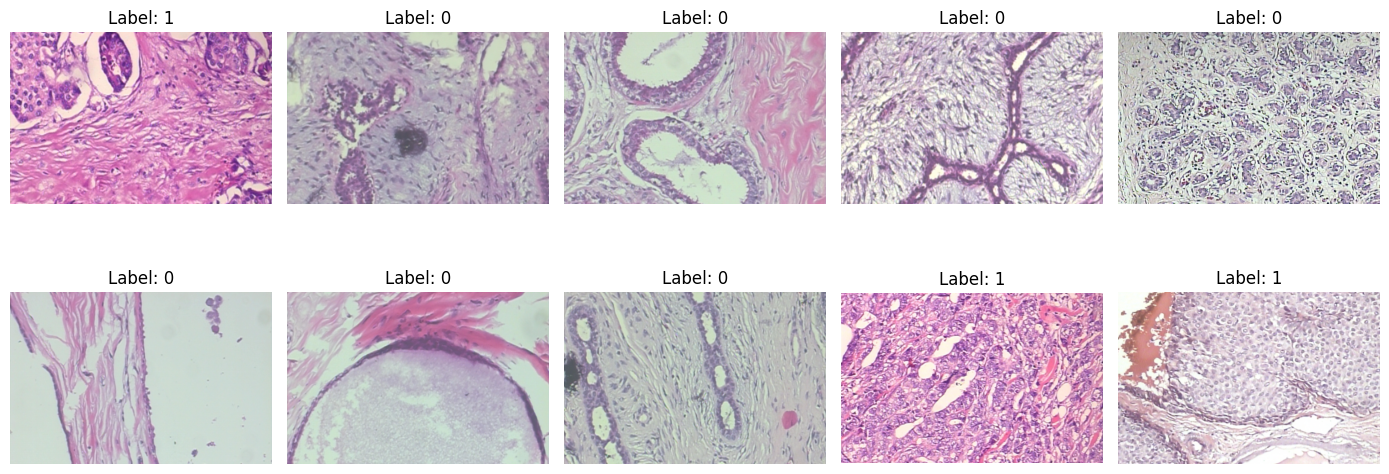

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()

for i, (image, label) in enumerate(train_ds):
    axes[i].imshow(image.numpy().astype(np.uint8))
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

    if i == 9:  # Display only the first 10 elements
        break

plt.tight_layout()
plt.show()

In [ ]:
for i, (image, label) in enumerate(train_ds):
    image = image.numpy().astype(np.uint8)
    filename = f'image_{i:04d}_{label}.png'
    image = Image.fromarray(image)
    if(label == 0):
      image.save(f'{WSI_directory_path}/train/benign/{filename}')
    elif(label == 1):
      image.save(f'{WSI_directory_path}/train/malignant/{filename}')


In [ ]:
images_patch_train, images_patch_labels_train = getPatchData(train_ds)
savePatches('train', images_patch_train, images_patch_labels_train)

(1800, 1, 224, 224, 3)


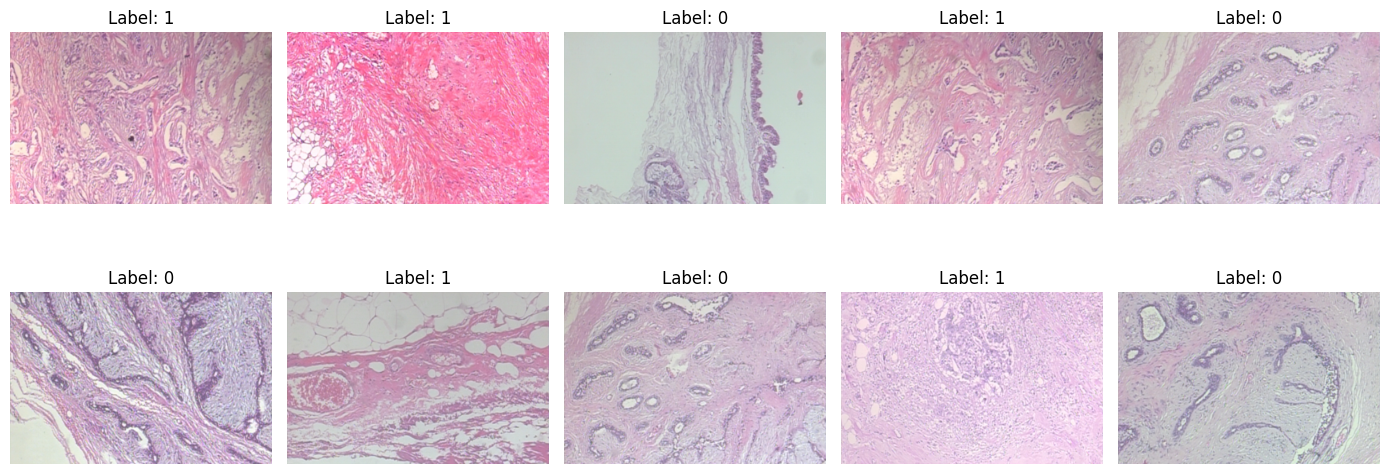

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()

for i, (image, label) in enumerate(validation_ds):
    axes[i].imshow(image.numpy().astype(np.uint8))
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

    if i == 9:  # Display only the first 10 elements
        break

plt.tight_layout()
plt.show()

In [ ]:
for i, (image, label) in enumerate(validation_ds):
    image = image.numpy().astype(np.uint8)
    filename = f'image_{i:04d}_{label}.png'
    image = Image.fromarray(image)
    if(label == 0):
      image.save(f'{WSI_directory_path}/validation/benign/{filename}')
    elif(label == 1):
      image.save(f'{WSI_directory_path}/validation/malignant/{filename}')


In [ ]:
images_patch_validation, images_patch_labels_validation = getPatchData(validation_ds)
savePatches('validation', images_patch_validation, images_patch_labels_validation)

(600, 1, 224, 224, 3)


In [ ]:
import os

folder_path = '/content/drive/MyDrive/Colab Notebooks/sample/validation/malignant'  # Replace with your folder path

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.startswith("image_"):
            parts = filename.split("_")
            i = int(parts[1])
            label = parts[2].split(".")[0]
            new_filename = f"image_{i:04d}_{label}.png"
            old_filepath = os.path.join(root, filename)
            new_filepath = os.path.join(root, new_filename)
            os.rename(old_filepath, new_filepath)